In [1]:
import os 
import sys

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import toast

import scipy.signal as si

import pysm3
import pysm3.units as usm

import skytools

import astropy.units as u 
import astropy as astro

from scipy.optimize import curve_fit
from scipy.linalg import sqrtm

In [2]:
from pixell import enmap, enplot, reproject, utils, curvedsky 
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm

In [3]:
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

In [4]:
env = toast.utils.Environment.get()
comm, procs, rank = toast.get_world()
nthread = os.environ["OMP_NUM_THREADS"]

In [5]:
mem = toast.utils.memreport(msg="(whole node)", comm=comm, silent=False)

Memory usage (whole node)
       total :  503.138 GB
   available :  139.180 GB
     percent :   72.300 % 
        used :  250.082 GB
        free :  108.690 GB
      active :   17.245 GB
    inactive :  293.196 GB
     buffers :    5.398 MB
      cached :  144.360 GB
      shared :   85.872 GB
        slab :   30.603 GB



In [6]:
def modulo_180(x):
    if x>180:
        return (x-360)
    else:
        return x

In [7]:
def modulo_360(x):
    if x<0:
        return (x+360)
    else:
        return x

In [8]:
modulo_180_vec = np.vectorize(modulo_180)
modulo_360_vec = np.vectorize(modulo_360)


0. Read Planck map

In [9]:
rGC = hp.rotator.Rotator(coord=['G','C'])  # Transforms galactic to equatorial coordinates
rCG = hp.rotator.Rotator(coord=['C','G'])  # Transforms equatorial to galactic coordinates


In [10]:
NSIDE = 512
lmax = 2*NSIDE

In [11]:
npix = hp.nside2npix(nside=NSIDE)

In [12]:
resol = hp.nside2resol(nside=NSIDE)
amin2rad = np.pi/(60*180)

resol_amin = resol*amin2rad

print(resol)

0.0019986849764579854


In [13]:
keys = {"downgrade": 8, "ticks": 10, "colorbar": True}  

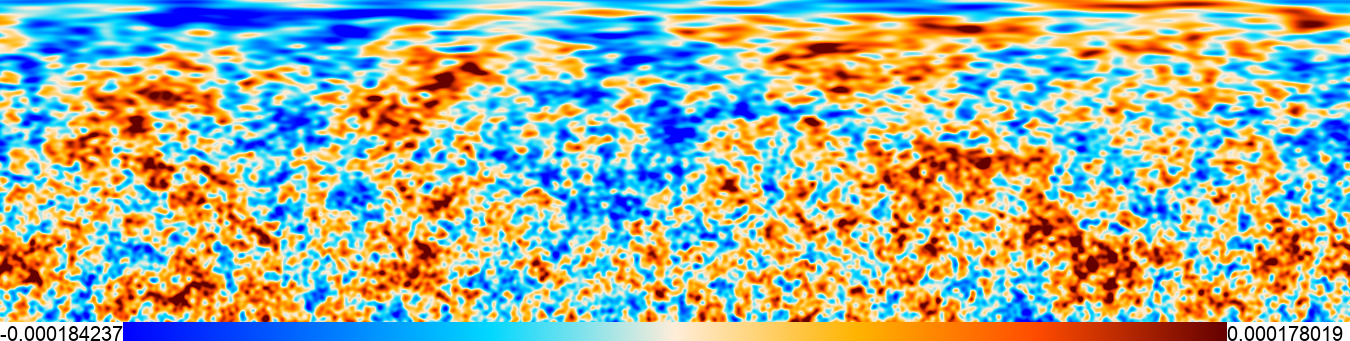

In [14]:
planck_map_car = enmap.read_map('cmb_030_GC_nside_I_car.FITS')
# Visualize using eshow
eshow(planck_map_car, **keys)

In [15]:
shape = planck_map_car.shape
wcs = planck_map_car.wcs

Create a telescope and corresponding pointing

1. Start by creating a focalplane with a sample rate and number of detectors

In [16]:
from toast.qarray import to_iso_angles, rotation, mult, to_lonlat_angles


In [17]:
xrot = rotation([0,1,0], np.pi/2)

#zrot = rotation([1,0,0], np.pi/2)


In [18]:
from toast.instrument_sim import fake_hexagon_focalplane, plot_focalplane

In [19]:
focalplane = toast.instrument.Focalplane(sample_rate=10*u.Hz#,thinfp=256
                                        )
##One fourth of total detectors in the focalplane
## For S4, sample rate ~10-100

with toast.io.H5File("focalplane_SAT3_SAT_f030.h5", "r", comm=comm, force_serial=True) as f:
            focalplane.load_hdf5(f.handle, comm=comm)

In [20]:
iso_angles = np.array([np.degrees(to_iso_angles(mult(xrot,focalplane[detec]["quat"]))) for detec in focalplane.detectors])


In [21]:
#iso_angles

In [22]:
focalplane._det_to_row = {'029_000_SAT_f030_A': 0,
  '029_003_SAT_f030_A': 6}

In [23]:
#iso_angles

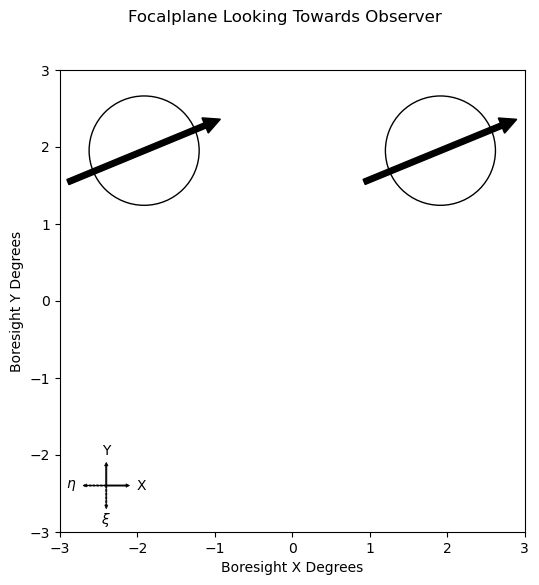

<Figure size 640x480 with 0 Axes>

In [24]:
plot_focalplane(focalplane, width=5*u.degree, height = 5*u.degree)
plt.savefig('two_detectors.png')

Print schedule information

In [25]:
schedule = toast.schedule.GroundSchedule()
schedule.read("POLE_DEEP_169-DEC0.txt", comm=comm)

TOAST INFO: Loading schedule from POLE_DEEP_169-DEC0.txt
TOAST INFO: Loaded 1 scans from POLE_DEEP_169-DEC0.txt totaling 84.0 minutes.


In [26]:
schedule

<GroundSchedule site=SOUTH_POLE at -90.0 deg, -44.65 deg, 2843.0 m telescope SAT with 1 scans
  <GroundScan 'POLE_DEEP' at 2000-01-01T12:00:00+00:00 with El = 54.52 deg, Az 118.39 deg -- 189.2 deg>
>

Print telescope information

In [27]:
site = toast.instrument.GroundSite(
        schedule.site_name,
        schedule.site_lat,
        schedule.site_lon,
        schedule.site_alt,
        weather=None,
    )
telescope = toast.instrument.Telescope(
        "My_telescope", focalplane=focalplane, site=site
    )

telescope

<Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -90.0 deg, alt = 2843.0 m, weather = None>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_003_SAT_f030_A]>>

We can have multiple groups for parallel computing (start with one). Create a Data Instance and simulate a ground observation operator.

In [28]:
toast_comm = toast.Comm(world=comm, groupsize=1)

In [29]:
data = toast.Data(comm=toast_comm)

In [30]:
sim_ground = toast.ops.SimGround(name="sim_ground", 
                                 weather="south_pole", 
                                 detset_key="pixel", 
                                 telescope = telescope, 
                                 schedule = schedule
                                ) ##simulate motion of the boresight

In [31]:
sim_ground.apply(data)

1. Create a focalplane with only two detectors in the same row with the same polarization
2. Two timestreams and see where scans overlap (?)
3. Fit a step function and substract it. How to adjust level at the end of overlap?
4. bin 

In [32]:
pointing = toast.ops.PointingDetectorSimple() ##boresight pointing into detector frame (RA/DEC by default)
pointing.apply(data)

2. Noise simulation

In [33]:
ob = data.obs[0]

In [34]:
time = ob.shared['times']

In [35]:
ntime = time.shape

In [36]:
#weights = toast.ops.StokesWeights(detector_pointing = pointing,mode = "I")
pixels = toast.ops.PixelsHealpix(detector_pointing = pointing, nside = NSIDE,nest=False)
pixels_wcs = toast.ops.pixels_wcs.PixelsWCS(detector_pointing = pointing,dimensions=shape#, resolution=(resol_amin/60*u.degree,resol_amin/60*u.degree)                                           )
                                           )

In [37]:
#scan_map = toast.ops.ScanHealpixMap(name="scan_healpix_map", file='cmb_030_GC_nside_I.FITS',pixel_pointing = pixels, stokes_weights = weights)
#scan_map.save_pointing = True#
#scan_map.apply(data)

In [38]:
pixels_wcs.pixels = 'pixels_wcs'

In [39]:
wcs

car:{cdelt:[-0.03333,0.03333],crval:[0,-56],crpix:[1290.00,5400.00]}

# Pixel pointing

By default, pixels are in NESTED ordering instead of RING!!!

In [40]:
pixels_wcs.apply(data)

In [41]:
pixels.apply(data)

In [42]:
pixels_wcs.pixels

'pixels_wcs'

In [43]:
ob.detdata

<DetDataManager 2 local detectors, 50400 samples
    signal: shape=(2, 50400), dtype=float64, units='K'
    flags: shape=(2, 50400), dtype=uint8, units=''
    quats: shape=(2, 50400, 4), dtype=float64, units=''
    pixels_wcs: shape=(2, 50400), dtype=int64, units=''
    pixels: shape=(2, 50400), dtype=int64, units=''>

In [44]:
pix_arr = ob.detdata['pixels']

pix_wcsarr = ob.detdata['pixels_wcs']

### Hitmap

In [45]:
def hitmap(ipix,nbpix=npix):
    hitmap = np.zeros(nbpix,dtype = float)
    for pix in ipix:
        hitmap[pix]+=1
    hitmap[hitmap==0] = hp.UNSEEN
    return(hitmap)

In [46]:
def presence(hitmap):
    presence = np.zeros(hitmap.shape)
    presence[(hitmap!=hp.UNSEEN)&(hitmap>0)] = 1
    presence[hitmap==hp.UNSEEN] = hp.UNSEEN
    return(presence)

In [47]:
hitmap1 = hitmap(ipix=pix_arr[0])
hitmap2 = hitmap(ipix=pix_arr[1])

In [48]:
hits1 = presence(hitmap1)
hits2 = presence(hitmap2)

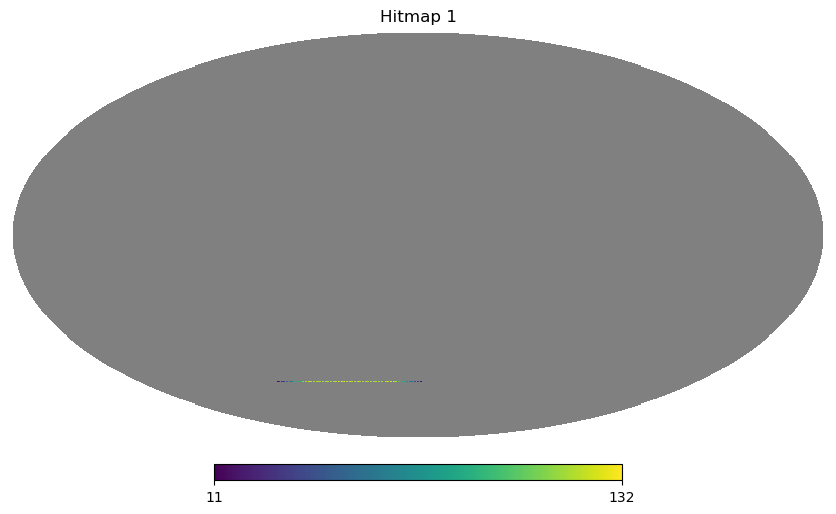

In [49]:
hp.mollview(hitmap1,title = 'Hitmap 1')

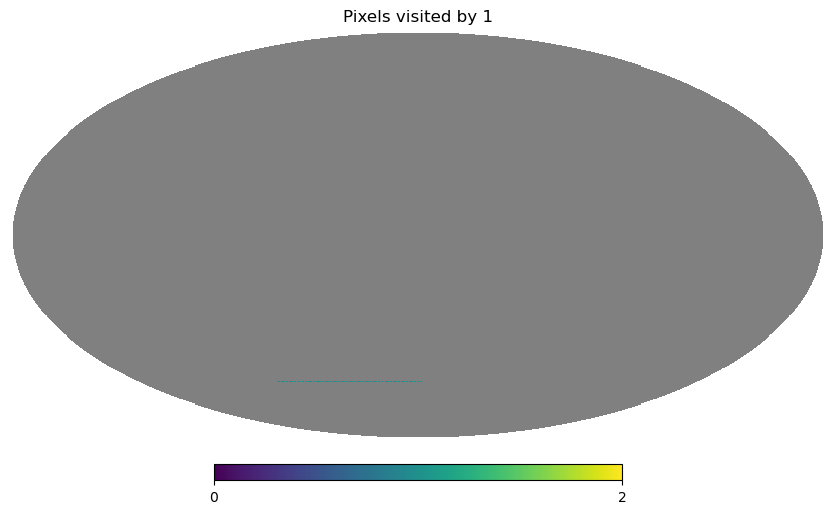

In [50]:
hp.mollview(hits1,title = 'Pixels visited by 1')

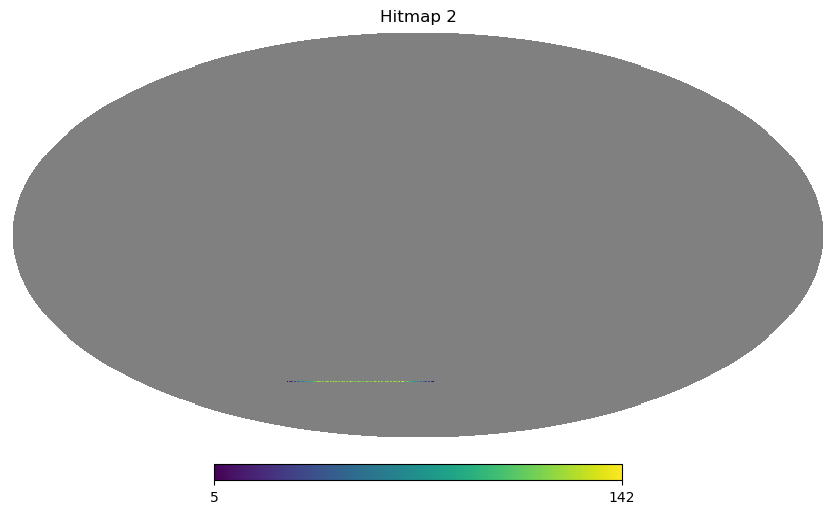

In [51]:
hp.mollview(hitmap2,title = 'Hitmap 2')

In [52]:
pixset1 = np.where(hits1!=hp.UNSEEN)[0]

pixset2 = np.where(hits2!=hp.UNSEEN)[0]

In [53]:
set1 = set(pixset1)
set2 = set(pixset2)

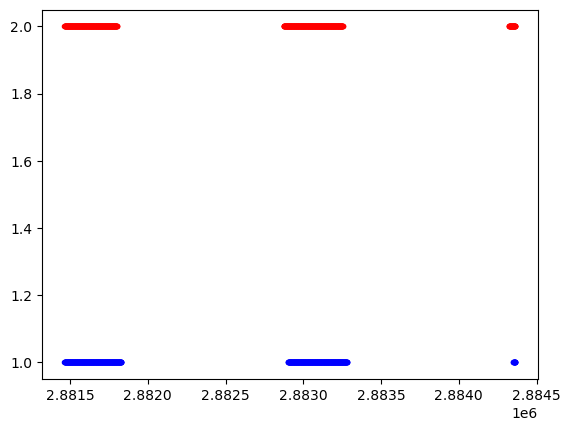

In [54]:
plt.plot(pixset1,hits1[pixset1],'b.')
plt.plot(pixset2,2*hits2[pixset2],'r.')
plt.show()

## WCS pixel ordering

In [55]:
wcs

car:{cdelt:[-0.03333,0.03333],crval:[0,-56],crpix:[1290.00,5400.00]}

In [56]:
shape

(2580, 10800)

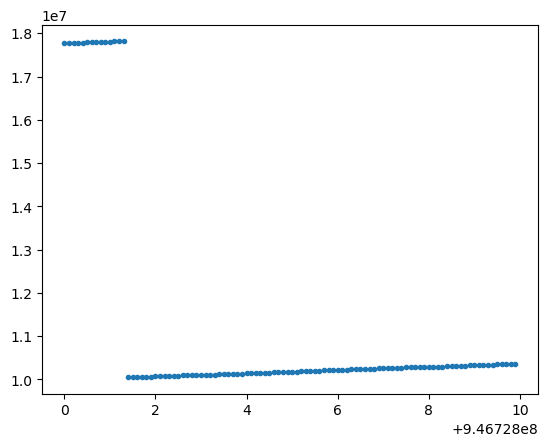

In [57]:
plt.plot(time[0:100],pix_wcsarr[0][0:100],'.')

In [58]:
shape

(2580, 10800)

In [59]:
pix_wcsarr[0][0:100]%(10800)

array([5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287,
       5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287,
       5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287,
       5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287,
       5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287,
       5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287,
       5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287,
       5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287,
       5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287, 5287,
       5287])

In [60]:
17782087-17771287

10800

In [61]:
(10366987-9072787)//1800

719

In [62]:
dec0,ra0 = enmap.pix2sky(shape=shape,wcs=wcs,pix=np.array([0,10]))

In [63]:
modulo_180_vec(np.degrees(dec0))


array(37.55091132)

In [64]:
np.degrees(ra0)

-121.32450451911994

In [65]:
def pix2coords(pix,shape):
    lon,lat = shape
    return(pix//lat,pix%lat)

In [66]:
pix2coords_vec = np.vectorize(pix2coords)

In [67]:
x_arr,y_arr = pix2coords(pix = pix_wcsarr[0],shape = shape)

In [68]:
x_arr[0]

1645

In [69]:
y_arr

array([5287, 5287, 5287, ..., 5287, 5287, 5287])

In [70]:
wcs

car:{cdelt:[-0.03333,0.03333],crval:[0,-56],crpix:[1290.00,5400.00]}

In [71]:
hitmap = enmap.zeros(planck_map_car.shape,planck_map_car.wcs)

In [72]:
ntime

(50400,)

In [73]:
for i in range(0,ntime[0]):
    hitmap[x_arr[i],y_arr[i]]+=1

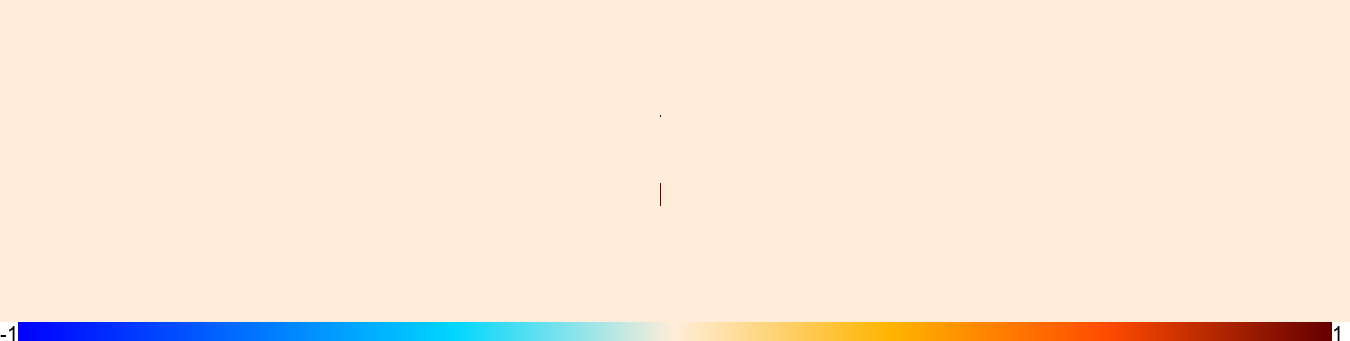

In [74]:
eshow(hitmap,**keys)

### Pixels to angles

In [75]:
ang_arr = hp.pix2ang(ipix=pix_arr,nside=NSIDE,nest=False,lonlat=True)

In [76]:
lonpix,latpix = ang_arr

In [77]:
lonpix,latpix

(array([[357.63812155, 357.88674033, 357.89256198, ...,  78.96694215,
          78.93646409,  78.6878453 ],
        [350.70247934, 350.92541436, 351.17403315, ...,  72.22375691,
          71.97513812,  71.72651934]]),
 array([[-56.44638083, -56.44638083, -56.35093615, ..., -56.35093615,
         -56.44638083, -56.44638083],
        [-56.35093615, -56.44638083, -56.44638083, ..., -56.44638083,
         -56.44638083, -56.44638083]]))

In [78]:
quats = ob.detdata['quats'][0]

In [79]:
quats.shape

(50400, 4)

In [80]:
quats_1 = ob.detdata['quats'][0]

In [81]:
boresight_radec = ob.shared['boresight_radec']
boresight_azel = ob.shared['boresight_azel']

In [82]:
ob.shared

<SharedDataManager
    times (column): shape=(50400,), dtype=float64
    position (column): shape=(50400, 3), dtype=float64
    velocity (column): shape=(50400, 3), dtype=float64
    azimuth (column): shape=(50400,), dtype=float64
    elevation (column): shape=(50400,), dtype=float64
    boresight_azel (column): shape=(50400, 4), dtype=float64
    boresight_radec (column): shape=(50400, 4), dtype=float64
    flags (column): shape=(50400,), dtype=uint8>

In [83]:
#iso_radec = np.degrees(to_iso_angles(mult(xrot,boresight_radec)))
iso_radec = np.degrees(to_lonlat_angles(boresight_radec))

In [84]:
phibs,thbs, psibs = iso_radec

In [85]:
iso_azel = np.degrees(to_lonlat_angles(boresight_azel))

In [86]:
iso_angpix1 = np.degrees(to_lonlat_angles(quats_1))


In [87]:
phi1,th1,psi1 = iso_angpix1


In [88]:
iso_angpix1

array([[ -2.3359727 ,  -2.16326955,  -1.99056641, ...,  79.03898647,
         78.86712169,  78.69525672],
       [-56.42096274, -56.42095812, -56.42095351, ..., -56.42039813,
        -56.42039581, -56.4203935 ],
       [-64.61601954, -64.6160245 , -64.61602948, ..., -64.62019492,
        -64.62018695, -64.62017896]])

In [89]:
iso_radec

array([[ -5.79305975,  -5.62035592,  -5.4476521 , ...,  75.58219181,
         75.41032677,  75.23846152],
       [-54.51918881, -54.51918404, -54.51917927, ..., -54.51848597,
        -54.51848393, -54.51848189],
       [-89.99726961, -89.99727385, -89.9972781 , ..., -90.0011824 ,
        -90.00117457, -90.00116674]])

In [90]:
difflat = latpix-th1
difflon = modulo_180_vec(lonpix-phi1)

In [91]:
print(np.degrees(ob.shared['elevation']))
print(np.degrees(ob.shared['azimuth']))

[54.52 54.52 54.52 ... 54.52 54.52 54.52]
[118.39       118.56228945 118.73457889 ... 178.71105805 178.53876881
 178.36647936]


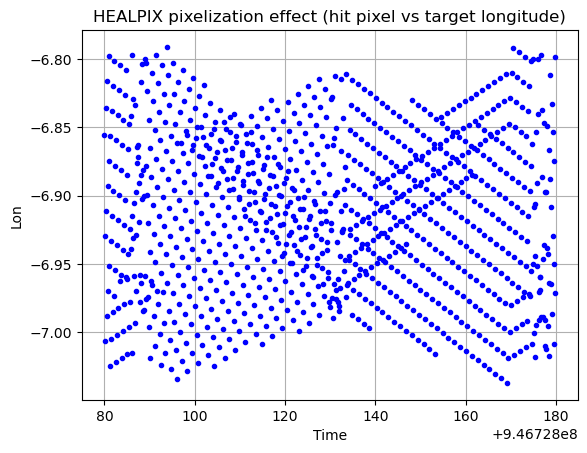

<Figure size 640x480 with 0 Axes>

In [92]:
plt.plot(time[800:1800],difflon[1,800:1800],'b.')
plt.xlabel('Time')
plt.ylabel('Lon')
plt.grid()
plt.title('HEALPIX pixelization effect (hit pixel vs target longitude)')
plt.show()
plt.savefig('pixelization_lon.pdf')

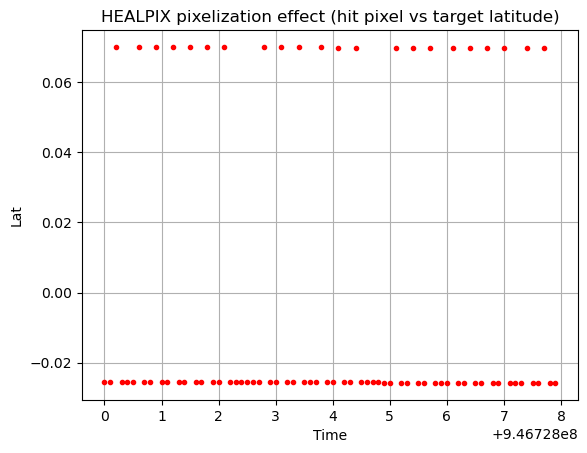

In [93]:
plt.plot(time[:80],difflat[0,:80],'r.')
plt.xlabel('Time')
plt.ylabel('Lat')
plt.grid()
plt.title('HEALPIX pixelization effect (hit pixel vs target latitude)')
plt.show()
#plt.savefig('pixelization_lat.pdf')

Assign each sample to corresponding ring

In [94]:
pixring = np.sign(difflat) ## if positive, upper row; if negative, lower row

In [95]:
pixring

array([[-1., -1.,  1., ...,  1., -1., -1.],
       [ 1., -1., -1., ..., -1., -1., -1.]])

In [96]:
modulo_180_vec(lonpix)

array([[-2.36187845, -2.11325967, -2.10743802, ..., 78.96694215,
        78.93646409, 78.6878453 ],
       [-9.29752066, -9.07458564, -8.82596685, ..., 72.22375691,
        71.97513812, 71.72651934]])

In [97]:
lonpix

array([[357.63812155, 357.88674033, 357.89256198, ...,  78.96694215,
         78.93646409,  78.6878453 ],
       [350.70247934, 350.92541436, 351.17403315, ...,  72.22375691,
         71.97513812,  71.72651934]])

ValueError: Wrong pixel number (it is not 12*nside**2)

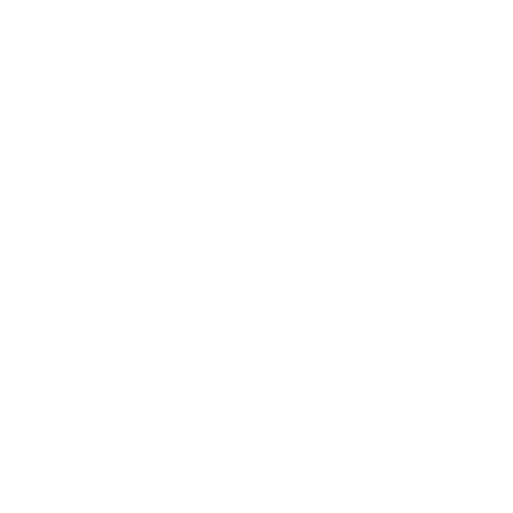

In [98]:
hp.gnomview(hitmap,rot = (0, -56.4),xsize = 600,ysize=200,reso = .1,title = 'Hitmap')
plt.savefig('Hitmap_pointing.png')

In [ ]:
hp.mollview(hitmap)

In [ ]:
plt.plot(time[:4000],(th1-thbs)[:4000],'b.')
plt.xlabel('Time')
plt.ylabel('Lon')
plt.grid()
#plt.title('HEALPIX pixelization effect (hit pixel vs target longitude)')
plt.show()
#plt.savefig('pixelization_lon.pdf')

In [ ]:
np.where(np.abs(iso_azel[2,:])<1e-6)

In [ ]:
np.where(np.abs(iso_azel[2,:])>1e-7)

In [ ]:
diff_el = np.degrees(ob.shared['elevation'])-iso_azel[1]

In [ ]:
print(diff_el)

In [ ]:
np.std(diff_el)

In [ ]:
plt.plot(time[:1000],ob.detdata['pixels'][0][:1000],'.')
plt.show()

In [ ]:
plt.plot(time[:100],pix_wcsarr[:100],'.')
plt.show()

In [ ]:
iso_angpix1

In [ ]:
coords = np.radians(iso_angpix1)

In [ ]:
coords[0:2].shape

In [ ]:
ypix,xpix = enmap.sky2pix(shape,wcs,coords=coords[0:2])

In [ ]:
shape

In [ ]:
xpix.shape

In [ ]:
hitmap_car = enmap.zeros(shape=shape,wcs=wcs,dtype=float)

In [ ]:
dec = -20 ; ra = 0

coords0 = np.deg2rad(np.array((dec,ra)))

ypix0,xpix0 = enmap.sky2pix(shape,wcs,coords0)

In [ ]:
print(ypix0,xpix0)

In [ ]:
hitmap_car.shape

In [ ]:
hitmap_car[:,:] = 100

In [ ]:
plots_hit = enplot.pshow(hitmap_car)

In [ ]:
enplot.show(plots_hit)

In [ ]:
hitmap_car

In [ ]:
pix_wcsarr[50:60]

In [ ]:
13602487-13591687

In [ ]:
(13602487-5837287)//10800

In [ ]:
plt.plot(time[:10000],iso_angpix1[1][:10000])
plt.show()

In [ ]:
peak1 = np.max(iso_angpix1[1][:1000])

In [ ]:
xpeak1 = np.where(iso_angpix1[1][:1000]==peak1)[0][0]

In [ ]:
peak1

In [ ]:
xpeak1

In [ ]:
peakf = np.max(iso_angpix1[1])

In [ ]:
xpeakf = np.where(iso_angpix1[1]==peakf)[0][0]

In [ ]:
print(peakf,xpeakf)

In [ ]:
drift = (peakf-peak1)/(time[xpeakf]-time[xpeak1])

In [ ]:
drift*3600*365.25*24

In [ ]:
360/3.6668485219649183